In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.preprocessing import MinMaxScaler
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

pd.options.mode.chained_assignment = None

In [2]:
file_name = 'pre_processado_completo.csv'

df = pd.read_csv(file_name, header=0, error_bad_lines=False, warn_bad_lines=False)

In [3]:
df.head()

,city,state,country,shape,duration_m,comments,latitude,longitude,date
0,san marcos,tx,us,cylinder,45.000000,This event took place in early fall around 194...,29.883056,-97.941111,1949-10-10
1,chester (uk/england),NaN,gb,circle,0.333333,Green/Orange circular disc over Chester&#44 En...,53.200000,-2.916667,1955-10-10
2,edna,tx,us,circle,0.333333,My older brother and twin sister were leaving ...,28.978333,-96.645833,1956-10-10
3,kaneohe,hi,us,light,15.000000,AS a Marine 1st Lt. flying an FJ4B fighter/att...,21.418056,-157.803611,1960-10-10
4,bristol,tn,us,sphere,5.000000,My father is now 89 my brother 52 the girl wit...,36.595000,-82.188889,1961-10-10


In [4]:
# limita o df aos USA

df_us = df.loc[df['country'] == 'us']
df_us.head()

,city,state,country,shape,duration_m,comments,latitude,longitude,date
0,san marcos,tx,us,cylinder,45.000000,This event took place in early fall around 194...,29.883056,-97.941111,1949-10-10
2,edna,tx,us,circle,0.333333,My older brother and twin sister were leaving ...,28.978333,-96.645833,1956-10-10
3,kaneohe,hi,us,light,15.000000,AS a Marine 1st Lt. flying an FJ4B fighter/att...,21.418056,-157.803611,1960-10-10
4,bristol,tn,us,sphere,5.000000,My father is now 89 my brother 52 the girl wit...,36.595000,-82.188889,1961-10-10
6,norwalk,ct,us,disk,20.000000,A bright orange color changing to reddish colo...,41.117500,-73.408333,1965-10-10


In [5]:
# define um array com as latitudes e longitudes

lat_lon = np.array(df_us[['longitude', 'latitude']]).astype(float)
print(len(lat_lon))
print(lat_lon)

75981
[[ -97.9411111   29.8830556]
 [ -96.6458333   28.9783333]
 [-157.8036111   21.4180556]
 ...
 [ -78.427222    39.078889 ]
 [ -74.163755    40.858433 ]
 [ -77.710548    34.367594 ]]


In [6]:
# define uma lista com os estados, e calcula o peso de cada estado de acordo com a quantidade de avistamentos, pelo método count

states = list(df_us['state'])
pesos = [states.count(s) for s in states]

In [8]:
scaler = MinMaxScaler()

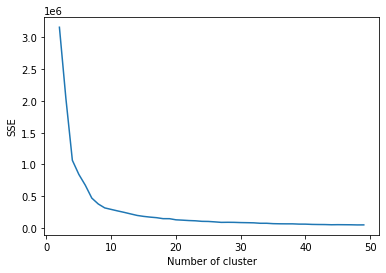

In [15]:
# aplica o elbow criteria

sse = {}
for k in range(2, 50):
    kmeans = KMeans(n_clusters=k, max_iter=2000).fit(scaler.fit_transform(lat_lon), sample_weight=pesos)
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

### Visto que o range para o Elbow Criteria foi grande, o número adequado de clusters está entre 5 e 20
#### A soma dos erros quadráticos não apresenta decaimento significante a partir desses valores, logo o gasto computacional para k_clusters maiores não se torna viável

### Para definir o melhor valor nesse range, foi utilizado o Coeficiente de Silhouette
#### quanto maior o coeficiente, menor a distância intracluster e maior a distância intercluster

In [16]:
# aplica o coeficiente de silhouette

for k in range(5, 21):
    kmeans = KMeans(n_clusters=k, max_iter=2000).fit(scaler.fit_transform(lat_lon), sample_weight=pesos)
    label = kmeans.labels_
    sil_coeff = metrics.silhouette_score(scaler.fit_transform(lat_lon), label, metric='euclidean')
    print("Para n_clusters={}, o coeficiente de  Silhouette {}".format(k, sil_coeff))

Para n_clusters=5, o coeficiente de  Silhouette 0.46936247594065367
Para n_clusters=6, o coeficiente de  Silhouette 0.4465803940598051
Para n_clusters=7, o coeficiente de  Silhouette 0.4357635319523501
Para n_clusters=8, o coeficiente de  Silhouette 0.4750653576037181
Para n_clusters=9, o coeficiente de  Silhouette 0.4888800284700376
Para n_clusters=10, o coeficiente de  Silhouette 0.5060874251432474
Para n_clusters=11, o coeficiente de  Silhouette 0.508043427199685
Para n_clusters=12, o coeficiente de  Silhouette 0.5246351405643096
Para n_clusters=13, o coeficiente de  Silhouette 0.5013236818356168
Para n_clusters=14, o coeficiente de  Silhouette 0.5020690345788484
Para n_clusters=15, o coeficiente de  Silhouette 0.4935329578245631
Para n_clusters=16, o coeficiente de  Silhouette 0.4785058146225632
Para n_clusters=17, o coeficiente de  Silhouette 0.4794653641482626
Para n_clusters=18, o coeficiente de  Silhouette 0.47061093046813185
Para n_clusters=19, o coeficiente de  Silhouette 0.4

### De acordo com o Coeficiente de Silhouette o número adequado de clusters é em torno de 12

In [17]:
# aplica o algoritmo kmeans, utilizando os pesos e normalizando os valores

kmeans = KMeans(n_clusters=12, max_iter=2000)
kmeans.fit(scaler.fit_transform(lat_lon), sample_weight=pesos)
lat_lon_scaled = np.array(scaler.fit_transform(lat_lon))
lat_lon_scaled

array([[0.70368241, 0.22674569],
       [0.71526142, 0.20989014],
       [0.16854746, 0.06903733],
       ...,
       [0.87812491, 0.39806994],
       [0.91623776, 0.43122398],
       [0.88453155, 0.31029551]])

In [18]:
centers = kmeans.cluster_centers_
centers

array([[0.90491276, 0.43863165],
       [0.49192544, 0.38115036],
       [0.70988263, 0.25116499],
       [0.53182923, 0.30145295],
       [0.80013884, 0.46291126],
       [0.49171738, 0.54638111],
       [0.8482383 , 0.19022923],
       [0.85454737, 0.324059  ],
       [0.63469375, 0.39307105],
       [0.24598364, 0.82241123],
       [0.17276895, 0.06187149],
       [0.79271117, 0.39064124]])

In [19]:
locations = kmeans.labels_.astype(float)
print(len(locations))
locations

75981


array([ 2.,  2., 10., ...,  0.,  0.,  7.])

Text(0, 0.5, 'Longitude')

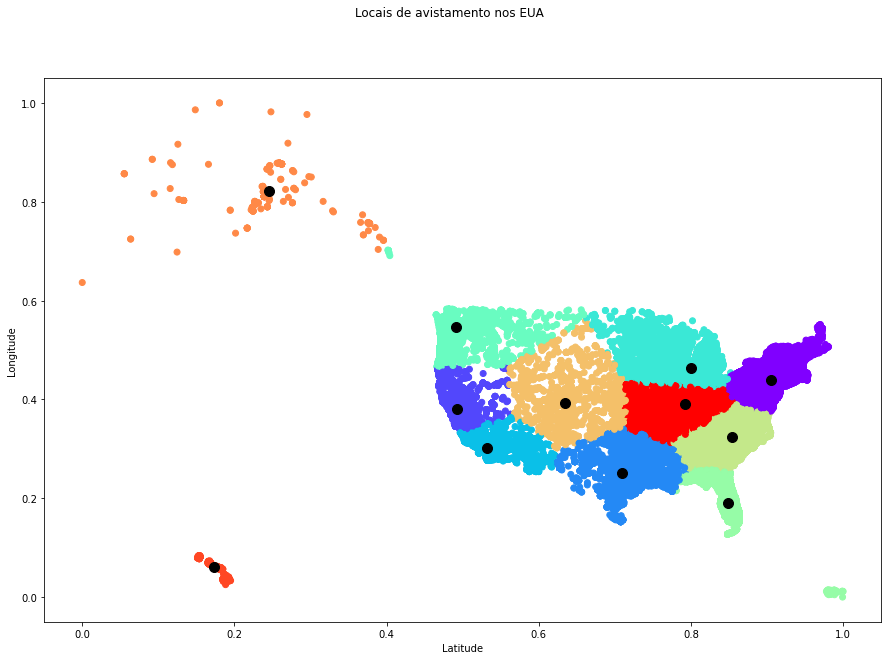

In [20]:
fig , ax = plt.subplots(figsize=(15, 10))
scatter = ax.scatter(lat_lon_scaled[:, 0], lat_lon_scaled[:, 1], c=locations, cmap='rainbow')
ax.scatter(centers[:, 0], centers[:, 1], c='black', s=100)
fig.suptitle('Locais de avistamento nos EUA')
plt.xlabel('Latitude')
plt.ylabel('Longitude')

Text(0, 0.5, 'Longitude')

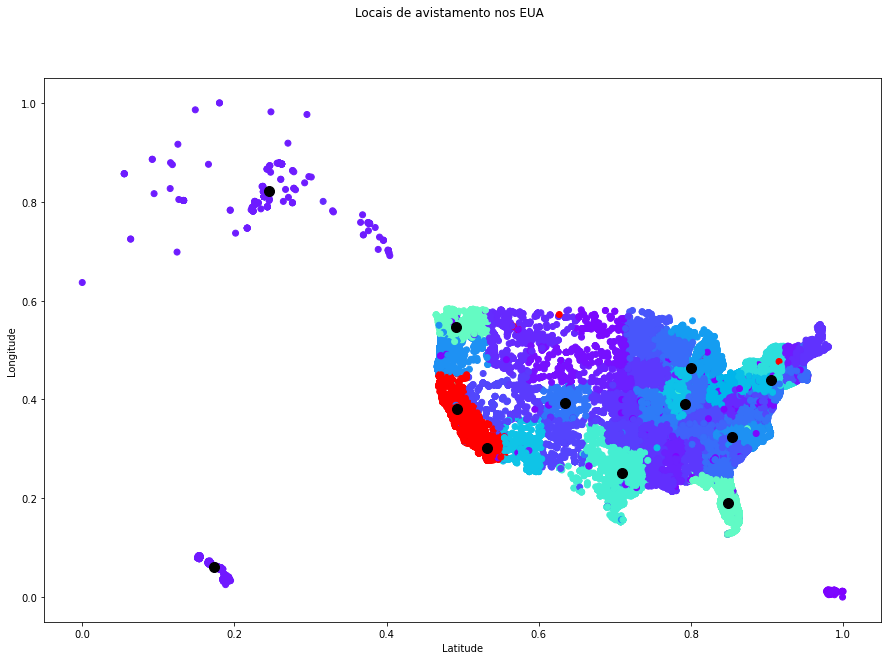

In [21]:
fig , ax = plt.subplots(figsize=(15, 10))
scatter = ax.scatter(lat_lon_scaled[:, 0], lat_lon_scaled[:, 1], c=pesos, cmap='rainbow')
ax.scatter(centers[:, 0], centers[:, 1], c='black', s=100)
fig.suptitle('Locais de avistamento nos EUA')
plt.xlabel('Latitude')
plt.ylabel('Longitude')

In [22]:
geolocator = Nominatim(user_agent="geoapiExercises")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
reverse = RateLimiter(geolocator.reverse, min_delay_seconds=1)

In [23]:
centers_notscaled = scaler.inverse_transform(centers)
centers_notscaled = centers_notscaled.tolist()

for i in range(len(centers_notscaled)):
    centers_notscaled[i][0], centers_notscaled[i][1] = centers_notscaled[i][1], centers_notscaled[i][0]

centers_notscaled = [tuple(center) for center in centers_notscaled]
centers_notscaled

[(41.256039606549145, -75.43061828118266),
 (38.170729938408876, -121.62915807348406),
 (31.193762030978892, -97.247527611462),
 (33.89296986951742, -117.16534759646325),
 (42.55924826046717, -87.1510798243905),
 (47.039494597265104, -121.65243211021752),
 (27.923033602460624, -81.77046726847298),
 (35.10634997717146, -81.06470720074785),
 (38.81057366833131, -105.65848003914418),
 (61.85541821015377, -149.1412665130919),
 (21.033429026815636, -157.3313769340782),
 (38.68015322021112, -87.98197156385295)]

In [25]:
address = [reverse(loc) for loc in centers_notscaled]

In [26]:
centers_states = []
for i in range(len(centers)):
    try:
        centers_states.append(address[i].raw['address']['state'])
    except:
        centers_states.append('NULL')
centers_states

['Pennsylvania',
 'California',
 'Texas',
 'California',
 'Wisconsin',
 'Washington',
 'Florida',
 'South Carolina',
 'Colorado',
 'Alaska',
 'NULL',
 'Illinois']

In [27]:
locations = list(locations)
locations = [int(item) for item in locations]
centers_states_all = [centers_states[loc] for loc in locations]
centers_states_all

['Texas',
 'Texas',
 'NULL',
 'South Carolina',
 'Pennsylvania',
 'South Carolina',
 'Florida',
 'California',
 'South Carolina',
 'Pennsylvania',
 'South Carolina',
 'South Carolina',
 'South Carolina',
 'Wisconsin',
 'Pennsylvania',
 'Pennsylvania',
 'Colorado',
 'South Carolina',
 'Washington',
 'Texas',
 'Illinois',
 'Pennsylvania',
 'Pennsylvania',
 'California',
 'Colorado',
 'Texas',
 'Texas',
 'Pennsylvania',
 'Texas',
 'Wisconsin',
 'Pennsylvania',
 'Wisconsin',
 'Pennsylvania',
 'Colorado',
 'Washington',
 'California',
 'Washington',
 'South Carolina',
 'South Carolina',
 'Pennsylvania',
 'Florida',
 'Texas',
 'South Carolina',
 'Texas',
 'Illinois',
 'South Carolina',
 'Pennsylvania',
 'Texas',
 'Wisconsin',
 'California',
 'Illinois',
 'South Carolina',
 'Illinois',
 'Illinois',
 'California',
 'South Carolina',
 'Wisconsin',
 'California',
 'California',
 'Wisconsin',
 'California',
 'California',
 'Washington',
 'South Carolina',
 'South Carolina',
 'California',
 'Illin

In [28]:
pd.set_option("max_colwidth", 120)
df_us['pesos'] = pesos
df_us['k-states'] = centers_states_all
df_us['k-centers'] = locations
df_us[['state', 'pesos', 'k-states', 'k-centers']].head(15)

,state,pesos,k-states,k-centers
0,tx,3969,Texas,2
2,tx,3969,Texas,2
3,hi,359,NULL,10
4,tn,1294,South Carolina,7
6,ct,1049,Pennsylvania,0
7,al,747,South Carolina,7
8,fl,4512,Florida,6
9,ca,10284,California,3
10,nc,1986,South Carolina,7
11,ny,3461,Pennsylvania,0
